**This was written in Python 2, if you are running Python 3, code translation may be necessary.**

### Cell Below Description:

1. Include all imports, dir path, and some function definitions.
2. Fetch all data and store into a dataframe: df_P

In [31]:
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime, date, time
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
import math
from matplotlib import dates

%matplotlib inline
#This is graph line style, from Nate silver
plt.style.use('fivethirtyeight')

#This is for the interactive plotting using bokeh
from bokeh.plotting import figure, output_file, show
from bokeh.models.markers import Asterisk
from bokeh.models import ColumnDataSource, DataRange1d, Plot, LinearAxis, Grid
from bokeh.models import HoverTool

#My mac directory path
#_DATA_DIR = r'/Users/schem001/Desktop/Diabetes Project/Diabetic-Project/input'
#_FIG_DIR = r'/Users/schem001/Desktop/Diabetes Project/Diabetic-Project/figures'

#My win directory path
_DATA_DIR = r'C:\Users\engadmin\Desktop\Diabetes  Project Code\Input\input'
_FIG_DIR = r'C:\Users\engadmin\Desktop\Diabetes  Project Code\figures'

if not os.path.exists(_FIG_DIR):
    os.makedirs(_FIG_DIR)
    
_GULCOSE_DATA_PATH = os.path.join(_DATA_DIR, 'P6.csv')
fields = ["Date", "mg/dL", "CHO (g)", "Fat (g)", "Protein (g)"]
df_P = pd.read_csv(_GULCOSE_DATA_PATH, parse_dates=['Date'], usecols = fields) #read and prase Date col as dataTimes object
df_P = df_P.sort_values(['Date'])

## Matplotlib Variables
_FIG_SIZE = (14, 6)
_FIG_FORMAT = 'png'
_FIG_DPI = 200

def _file_format(string_):
    string_ = string_.replace('-', '_').replace(' ', '_').replace('$', '')
    string_ += '.' + _FIG_FORMAT
    return string_

#For printing full elements of dataframe or array
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
pre_recording_mins = 15 #Minutes that may have elapsed before patient has recorded the reading
gl_increase = 20 #15mg/dL increase because we are interested in meals for now, later we can include sncaks
gl_decrease = 20 #15mg/dl of glucose drop (we noticed from the data that 10mg/dl would be too low and may result in not finding the highest peak after meal)

### Cell Below Description: 

1. Remove NaN BG readings from the dataframe: df_Pv2


2. Add succesive meal recordings and store under one reading. Store all meals data in a dataframe: df_P_meals



Total number of glucose readings is: 7915

-------------------------------------------

Combine succesive meal readings (CHO, fat, protein), occuring within a 30 minute window,...


Total of 109 recorded meals.


A sample (head) of the meals dataframe...

                 Date  mg/dL  CHO (g)  Fat (g)  Protein (g)
0 2008-08-04 19:07:00   96.0  120.777  23.7115       59.798
1 2008-08-05 07:02:00  112.0   28.209   7.0635        6.562
2 2008-08-05 12:02:00   90.0   30.380   9.2195       32.022
3 2008-08-05 16:47:00   84.0   14.310   0.3800        1.370
4 2008-08-05 19:52:00  105.0   89.430  24.7800       37.490
BG average for this patient is: 112.933796589 with a std of 14.8972870353


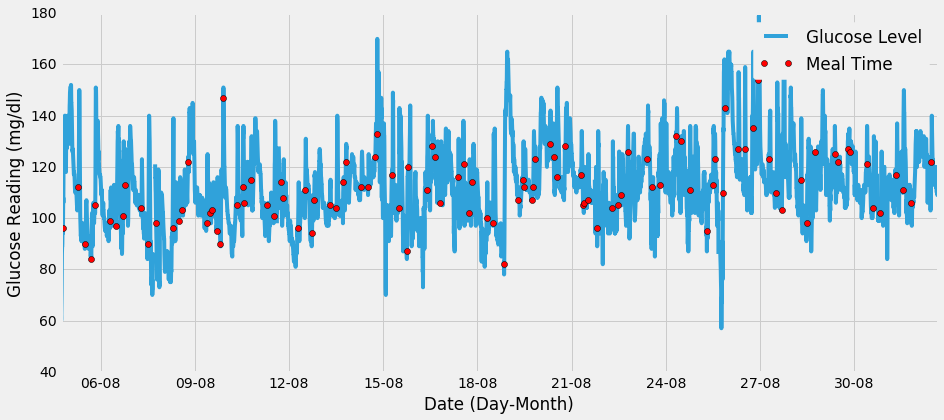

In [32]:
#Task 1

#print "\nTotal number of glucose readings for this patient is:", df_P['mg/dL'].size
#print "\nRecordings inbetween may be missing, the above number represents the collected readings from start date to end date."

#Removing NaN from a specific column of the dataframe, here it's mg/dL
df_P_wonan_mg = df_P.dropna(subset=['mg/dL'])
#print "\nRemove NaN from the mg/dL column...\n"
print "\nTotal number of glucose readings is:", df_P_wonan_mg['mg/dL'].size

#Converting object type to float for all of the dataframe (df_Pv2 stands for dataframe, patient, version 2)
df_Pv2= pd.DataFrame(df_P_wonan_mg).convert_objects(convert_numeric=True)

#Task 2
print "\n-------------------------------------------"
#Get Meal dataframe

#print "\nRemove NaN from the CHO so we can plot the points of meals..."
df_Pv2 = df_Pv2.dropna(subset=['CHO (g)'])
#print "\nNumber of meals recorded is:", df_Pv2['CHO (g)'].size
#print "\nSome of the successive meal readings stand for one meal with many servings."

df_Pv2 = df_Pv2.reset_index(drop=True)

df_P_meals = copy.deepcopy(df_Pv2)

print '\nCombine succesive meal readings (CHO, fat, protein), occuring within a 30 minute window,...' 

#Task 3
row = 0
i = 0   
while (i < (df_Pv2['CHO (g)'].size-1)):
    k = i
    row = row + 1         
   
    minutesdiff = df_Pv2.Date[k+1] - df_Pv2.Date[k]
    
    #If the meals are within 30 minutes of each other, combine into one
    while ((minutesdiff.seconds / 60 <= 30)):
        #drop this row but add CHO and fats and proteins to values of previous row
        k = k+1
        df_P_meals.set_value(row-1,'CHO (g)',df_P_meals['CHO (g)'][row-1]+df_P_meals['CHO (g)'][row])
        df_P_meals.set_value(row-1,'Fat (g)',df_P_meals['Fat (g)'][row-1]+df_P_meals['Fat (g)'][row])
        df_P_meals.set_value(row-1,'Protein (g)',df_P_meals['Protein (g)'][row-1]+df_P_meals['Protein (g)'][row])
        df_P_meals.drop(df_P_meals.index[row], axis=0, inplace=True)
        df_P_meals = df_P_meals.reset_index(drop=True)
        if (k == (df_Pv2['CHO (g)'].size-1)):
            break   
        minutesdiff = df_Pv2.Date[k+1] - df_Pv2.Date[k]
    i = k+1               

df_P_meals = df_P_meals.reset_index(drop=True)
print "\n\nTotal of", df_P_meals['CHO (g)'].size, "recorded meals.\n" 

print "\nA sample (head) of the meals dataframe...\n\n", df_P_meals.head()

plt.figure(figsize=_FIG_SIZE)
plt.plot_date(df_P.Date, df_P['mg/dL'], '-', label="Glucose Level");
plt.plot_date(df_P_meals.Date, df_P_meals['mg/dL'], 'ro', label="Meal Time")
plt.xlabel('Date (Day-Month)')
plt.ylabel('Glucose Reading (mg/dl)')
plt.legend(loc='upper right')
title = ''
ax=plt.gca()
xfmt = dates.DateFormatter('%d-%m')
#xfmt = dates.DateFormatter('%d-%m-%y %H:%M')
ax.xaxis.set_major_formatter(xfmt)

plt.title(title);

#For later use, maybe
#Last non empty row of patient data
nonempty_P_readings = df_P[pd.notnull(df_P['Date'])]
nonempty_readings = df_P[pd.notnull(df_P['Date'])]
last_row_date = nonempty_readings.iloc[-1, nonempty_readings.columns.get_loc('Date')]


print "BG average for this patient is:", np.mean(df_P_wonan_mg['mg/dL']), "with a std of", np.std(df_P_wonan_mg['mg/dL'])

#print df_P.iloc[140:,]

### Interactive Plot of raw CGM data with meal recordings

In [33]:
#output to static HTML file
output_file("Raw_CGM.html")

plot = figure(plot_width=1250, plot_height=600, title="",
              tools='pan,wheel_zoom,reset,box_zoom,save, undo', x_axis_type='datetime')

plot.line(df_P.Date, df_P['mg/dL'],  line_width=4, line_alpha=0.5)
plot.square(df_P.Date, df_P['mg/dL'], legend="Glucose Readings", fill_color=None, line_color="grey")

good_readings = ColumnDataSource(dict(x=df_P_meals.Date, y=df_P_meals['mg/dL'], z=df_P_meals['CHO (g)'], k = df_P_meals['Fat (g)'], d = df_P_meals['Protein (g)']))

g1 = plot.asterisk(x=df_P_meals.Date, y=df_P_meals['mg/dL'], legend = 'Meal Recordings', line_color="#f0027f", fill_color=None, line_width=8, source=good_readings)

plot.add_tools(HoverTool( renderers = [g1],  tooltips= [
    ('Glucose (mg/dL)', '@y'),
    ('CHO (g)', '@z'),
    ('Fat (g)', '@k'),
    ('Protein (g)', '@d')
]))

plot.xaxis.axis_label = "Date & Time"
plot.yaxis.axis_label = "BG Concentration (mg/dL)"

show(plot) 

### Current Patient's meal size histogram & Stats

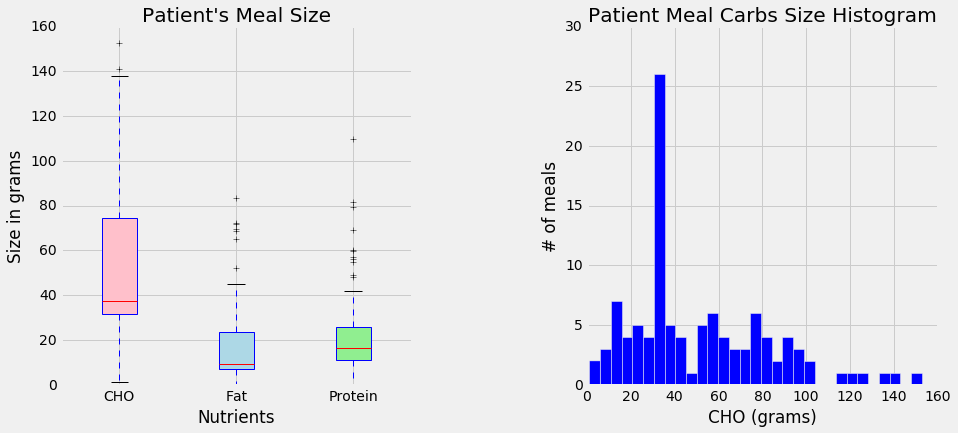

In [34]:
bins =  int(math.ceil(np.max(df_P_meals['CHO (g)'])/5))#bins of 5 grams

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
######################Box Plot
# rectangular box plot
bplot1 = axes[0].boxplot([df_P_meals['CHO (g)'],df_P_meals['Fat (g)'], df_P_meals['Protein (g)']],
                         vert=True,   # vertical box aligmnent
                         patch_artist=True)
# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)

# add x-tick labels
plt.setp(axes[0], xticks=[y+1 for y in range(3)],
         xticklabels=['CHO', 'Fat', 'Protein'])

axes[0].set_xlabel('Nutrients')
axes[0].set_ylabel('Size in grams')
axes[0].set_title('Patient\'s Meal Size')

#####################Histogram of CHO
bplot0 = axes[1].hist(df_P_meals['CHO (g)'], bins, facecolor='blue', alpha=1)
axes[1].set_xlabel('CHO (grams)')
axes[1].set_ylabel('# of meals')
axes[1].set_title('Patient Meal Carbs Size Histogram')
fig.subplots_adjust(wspace=0.5)

plt.show()

#n, bins, patches = plt.hist(df_P_meals['CHO (g)'], bins, facecolor='blue', alpha=1)

#print "For this patient, the meal Carbs mean is:", round(np.mean(df_P_meals['CHO (g)']),2), "grams with a std of:",round(np.std(df_P_meals['CHO (g)']),2), "grams."

#  Assumptions for Data Cleaning

In [35]:
print "\n\nData Cleaning...\n"



Data Cleaning...



**a. Remove meals that have several missing BG readings within their postprandial period**

The selected window is under window_size_minutes. i.e: 23 represents a window of (23*5)+5 = 120 mintues

In [36]:
print "\n-------------Condition 1-------------------"
print "\nRemove meal data points with several missing BG readings in their postprandial window...\n"

#This chunk of code implements the first condition, which removes the meals that have significant missing successive points
import datetime

df_P_meals_w_deletion = copy.deepcopy(df_P_meals)

#variables
incr = 5 #Data was recorded at 5 minutes increments
#window_size = 23 #This represents window size based on increments of 5.

window_size_minutes = 90# in minutes
window_size = (window_size_minutes / 5) - 1

del_points_df_a = pd.DataFrame()#Dataframe containing meal to be deleted by this assumption
points_to_del_a = []

for x in range(df_P_meals_w_deletion['CHO (g)'].size):
    a = df_P_meals_w_deletion['Date'][x]
    b = a
    count = 0
    for j in range(window_size):
        b += datetime.timedelta(minutes=incr)
        reading = df_P.loc[df_P['Date'] == b]['mg/dL']
        try:
            reading.values[0]
        except IndexError:
            #print "Index out of range"
            count +=1 
            continue  
        if (math.isnan(reading.values[0])):
            count +=1
    #If eight of the window size has missing values, exclude that meal
    if (count > ((window_size+1)/8)):
        print "\nThe meal at", a, "has", count,"missing readings within its following {}".format((window_size+1)*5),"minutes. Thus, it will be removed."
        #Put this into a dataframe to plot later with different color
        del_points_df_a = del_points_df_a.append(df_P.loc[df_P['Date'] == a])        
        points_to_del_a.extend([x])  

#Remove the above detected points from dataset
df_P_meals_w_deletion.drop(df_P_meals_w_deletion.index[points_to_del_a],axis=0,inplace=True)
df_P_meals_w_deletion = df_P_meals_w_deletion.sort_values(['Date'])
df_P_meals_w_deletion = df_P_meals_w_deletion.reset_index(drop=True)

if (df_P_meals_w_deletion['CHO (g)'].size == df_P_meals['CHO (g)'].size):
    print "There are no meals that need to be excluded, at this stage.\n"

print "\nThere are", df_P_meals_w_deletion['CHO (g)'].size, "remaining meal recordings.\n" 


-------------Condition 1-------------------

Remove meal data points with several missing BG readings in their postprandial window...

There are no meals that need to be excluded, at this stage.


There are 109 remaining meal recordings.



**b. Delete meals which do not have a significant BG increase in their postprandial signal (i.e: 15mg/dl).**

**We are defining a postprandial signal to be between the meal time until the second point of significant increase, which is most likely the next meal**

*We start few minutes before the meal was recorded, just in case the meal was recorded few minutes after food intake.

If no significant increase is apparent, we delete the meal point.

In [37]:
print "\n-------------Condition 2-------------------"

#This chunk of code implements the second constraint, removing meals which do not have a significant postprandial glucose increase
df_P_meals_w_deletion_b = copy.deepcopy(df_P_meals_w_deletion)

incr = 5 #Data was collected at 5 minutes increments- Do not change this
glucose_effect_window = 45 #Minutes food may take to be reflected on the blood glucose
#Change below to higher minutes if glucose increases slowly
gl_increase_window = 45 #Minutes from the instance where the glucose is reflected on the blood to significant increase


print "\nRemove meal data points which do NOT have significant BG INCREASE, at least",gl_increase,"mg/dl, in their postprandial window...\n"


#May want to change VARIABLES above for different patients, especially if food takes a while to affect their glucose level

meal_affect_window = [i for i in np.arange(-(pre_recording_mins), glucose_effect_window+incr+incr, incr)] #glucose_effect_window+incr+incr, so we account from 0mins to 45mins included

compare_window = [j for j in np.arange(incr, gl_increase_window+incr, incr)]

points_to_del_b = []
del_points_df_b = pd.DataFrame()#Dataframe containing meal to be deleted by this assumption
low_surrounding_gl = pd.DataFrame()#Dataframe containing points where the glucose will go to take a significant increase, not necessarily the very lowest points
high_surrounding_gl = pd.DataFrame()
offset_low_point_to_meal = []

for x, item in enumerate(df_P_meals_w_deletion_b['Date']):
    
    a = df_P_meals_w_deletion_b['Date'][x]
    meal_reading = df_P.loc[df_P['Date'] == item]['mg/dL']
    b = item - datetime.timedelta(minutes=pre_recording_mins) 
    keep = 0
    
    for i in meal_affect_window:
        
        if (i == meal_affect_window[-1]):
        #print "The meal reading taken at" ,a, "should be deleted."            
        #print "The reading that is about to be removed has the following size, CHO", round(df_P_meals_w_deletion_b['CHO (g)'][x],2),"g, Proteins", round(df_P_meals_w_deletion_b['Protein (g)'][x],2),"g, Fats", round(df_P_meals_w_deletion_b['Fat (g)'][x],2),"g"

            #Put this into an dataframe to plot with different color
            del_points_df_b = del_points_df_b.append(df_P.loc[df_P['Date'] == item])
            #Also remove this from dataset   
            points_to_del_b.extend([x])
            break
        
        current_reading = df_P.loc[df_P['Date'] == b]['mg/dL']
        try:
            current_reading.values[0]
        except IndexError:
            #print "Index out of range"
            b += datetime.timedelta(minutes=incr)   
            continue            
        if (math.isnan(current_reading.values[0])):
            b += datetime.timedelta(minutes=incr)  
            continue      
            
        c = b
        for k in compare_window:#comparing the point with its following readings in compare window size
            c += datetime.timedelta(minutes=incr)
            compare_reading = df_P.loc[df_P['Date'] == c]['mg/dL']
            if ((compare_reading.values[0] - current_reading.values[0]) >=gl_increase):
                #Store this reading on a dataframe of low readings surrounding meals
                low_surrounding_gl = low_surrounding_gl.append(df_P.loc[df_P['Date'] == b])
                high_surrounding_gl = high_surrounding_gl.append(df_P.loc[df_P['Date'] == c])
                #print "a is:", a, "and b is:", b, "and c is:", c, "and difference between b and c is:", (c - b)
                if (b<item):
                    offset_low_point_to_meal.extend([int(-(item-b).seconds / 60)])
                    #print "The time elapsed between original meal time and surrounding low point is:", "-", (a-b).seconds / 60 ,"minutes."        
                else:
                    offset_low_point_to_meal.extend([int((b-item).seconds / 60)])
                    #print "The time elapsed between original meal time and surrounding low point is:", "+", (b-a).seconds / 60 ,"minutes."  
                keep = 1  
                break
                
        if (keep == 1):
            break
        b += datetime.timedelta(minutes=incr)    
        
print "\n", len(points_to_del_b), "meal recordings are to be removed."

df_P_meals_w_deletion_b.drop(df_P_meals_w_deletion_b.index[points_to_del_b],axis=0,inplace=True)
df_P_meals_w_deletion_b = df_P_meals_w_deletion_b.sort_values(['Date'])
df_P_meals_w_deletion_b = df_P_meals_w_deletion_b.reset_index(drop=True)

print "\nThere are", df_P_meals_w_deletion_b['CHO (g)'].size, "remaining meal time recordings.\n" 

low_surrounding_gl = low_surrounding_gl.sort_values(['Date'])
low_surrounding_gl = low_surrounding_gl.reset_index(drop=True)

high_surrounding_gl = high_surrounding_gl.sort_values(['Date'])
high_surrounding_gl = high_surrounding_gl.reset_index(drop=True)

df_P_meals_w_deletion_v2 = copy.deepcopy(df_P_meals_w_deletion_b)


-------------Condition 2-------------------

Remove meal data points which do NOT have significant BG INCREASE, at least 20 mg/dl, in their postprandial window...


50 meal recordings are to be removed.

There are 59 remaining meal time recordings.



### Interactive Plot of meal recordings to be removed after above conditions

In [38]:
# # output to static HTML file, remaining meals, meals to be deleted after assumption a and b
# output_file("All_Data_with_Deletion.html")

# plot = figure(plot_width=1250, plot_height=600, title="Glucose Readings Interactive Plot",
#               tools='pan,wheel_zoom,reset,box_zoom,save, undo', x_axis_type='datetime')

# plot.line(df_P.Date, df_P['mg/dL'],  line_width=2, line_alpha=0.6)
# plot.square(df_P.Date, df_P['mg/dL'], legend="Glucose Readings", fill_color=None, line_color="grey")

# good_readings = ColumnDataSource(dict(x=df_P_meals_w_deletion_v2.Date, y=df_P_meals_w_deletion_v2['mg/dL'], z=df_P_meals_w_deletion_v2['CHO (g)'], k = df_P_meals_w_deletion_v2['Fat (g)'], d = df_P_meals_w_deletion_v2['Protein (g)']))
# g1 = plot.asterisk(x=df_P_meals_w_deletion_v2.Date, y=df_P_meals_w_deletion_v2['mg/dL'], legend = 'Meal Recordings', line_color="#f0027f", fill_color=None, line_width=8, source=good_readings)

# if (len(points_to_del_a) != 0):
#     plot.asterisk(x=del_points_df_a.Date, y=del_points_df_a['mg/dL'],legend = 'Meal to be deleted after condition a', line_color="#32CD32", fill_color=None, line_width=8)

# if (len(points_to_del_b) != 0):    
#     plot.asterisk(x=del_points_df_b.Date, y=del_points_df_b['mg/dL'],legend = 'Meal to be deleted after condition b', line_color="#0404B4", fill_color=None, line_width=8)

# plot.add_tools(HoverTool( renderers = [g1],  tooltips= [
#     ('Glucose (mg/dL)', '@y'),
#     ('CHO (g)', '@z'),
#     ('Fat (g)', '@k'),
#     ('Protein (g)', '@d')
# ]))

# plot.xaxis.axis_label = "Date & Time"
# plot.yaxis.axis_label = "BG Concentration (mg/dL)"

# show(plot) 


**Dataframe that contains meal times after deletion of abnormal meal recordings is: df_P_meals_w_deletion_v2**

## Detecting postprandial peaks

Steps:

1. Detect a significant glucose drop. 

2. Find the highest glucose point up to that drop point

3. If a significant drop was not found after the postprandial peak, remove that meal point


In [39]:
print "\n-------------Condition 3-------------------"

#Step 1


minutes2peak = 90#Minutes to reach the peak after highest surrounding point detected before
gl_decrease_window = 90 #Minutes it takes for a significant glucose decrease after meal, it may take long time for glucose to go down, few hours

print "\nRemove meal data points which do NOT have significant BG DECREASE, at least",gl_decrease,"mg/dl, following their postprandial peak...\n"

up2peak_window = [j for j in np.arange(0, minutes2peak+incr+incr, incr)]
compare_window = [j for j in np.arange(incr, gl_decrease_window+incr, incr)]

afterpeak_lowgl_df = pd.DataFrame()#This dataframe contains the points after the glucose drop following the peak
lowpoint_to_del_df = pd.DataFrame()#Dataframe contaning any meal recording to be deleted because they do not have a significant nearby glucose drop after the increase
peak_points_df = pd.DataFrame()#Dataframe containing peak points following meal times
lowpoint_to_del = []

for x, item in enumerate(high_surrounding_gl['mg/dL']):   
    a = high_surrounding_gl['Date'][x]   
    keep = 0
    b= a

    for i in up2peak_window:
        current_reading = df_P.loc[df_P['Date'] == b]['mg/dL']
        c = b

        if (i == up2peak_window[-1]):
            #print "Could not detect a significant glucose drop after this meal recording", df_P_meals_w_deletion_v2['Date'][x], ". It is suggested to delete it"  
            #print "current reading is: ", current_reading, "at date", df_P.loc[df_P['Date'] == b]
            lowpoint_to_del.extend([x])  
            lowpoint_to_del_df = lowpoint_to_del_df.append(df_P.loc[df_P['Date'] == a])
            break
        
        for k in compare_window:#comparing the point with its following readings in compare window size
            c += datetime.timedelta(minutes=incr)
            compare_reading = df_P.loc[df_P['Date'] == c]['mg/dL']
            try:
                compare_reading.values[0]
            except IndexError:
                #print "Index out of range"
                continue   

            #print "current", current_reading.values[0]
            #print "compare", compare_reading.values[0]
            #if (~np.isnan(compare_reading.values[0])):
            if ((current_reading.values[0] - compare_reading.values[0]) >= gl_decrease) :#significant glucose drop has been detected
                #Store this reading on a dataframe of points detecting glucose drop after peak
                afterpeak_lowgl_df = afterpeak_lowgl_df.append(df_P.loc[df_P['Date'] == c])
                keep = 1
                break
            #else:
            #    continue
                
        if (keep == 1):
            break   
               
        b += datetime.timedelta(minutes=incr)    

afterpeak_lowgl_df = afterpeak_lowgl_df.reset_index(drop=True)
lowpoint_to_del_df = lowpoint_to_del_df.reset_index(drop=True)

condition3_df = copy.deepcopy(df_P_meals_w_deletion_v2)
condition3_index =[]
for k in range (df_P_meals_w_deletion_v2.shape[0]):
    if (k not in lowpoint_to_del):
        condition3_index.append(k)

#print len(lowpoint_to_del)
#print len(condition3_index)
condition3_df.drop(condition3_df.index[condition3_index],axis=0,inplace=True)  
condition3_df = condition3_df.reset_index(drop=True)

print condition3_df.shape[0]

#step 3
#print "Could not detect a significant glucose drop after the following meal recordings:\n\n",lowpoint_to_del_df['Date']
#Drop x from the "all the meals" dataframe 
df_P_meals_w_deletion_v2.drop(df_P_meals_w_deletion_v2.index[lowpoint_to_del],axis=0,inplace=True)  
df_P_meals_w_deletion_v2 = df_P_meals_w_deletion_v2.reset_index(drop=True)

low_surrounding_gl.drop(low_surrounding_gl.index[lowpoint_to_del],axis=0,inplace=True)  
low_surrounding_gl = low_surrounding_gl.reset_index(drop=True)

#print df_P_meals_w_deletion_v2


#Step 2

#print "\nThe dataframe of the points after detecting a glucose drop:\n", afterpeak_lowgl_df 
def drange(start, stop, step):
    while start <= stop:
            yield start
            start += step

#####This portion of the code is to detect the post-meal peak            
for x, item in enumerate(afterpeak_lowgl_df['mg/dL']):
    #print "At the meal of date", df_P1_meals_w_deletion['Date'][x], "the lowest point is at:", surrounding_lowest_points_df['Date'][x] , "and low after peak is at:", afterpeak_lowgl_df['Date'][x]  
    a = low_surrounding_gl['Date'][x]
    #print "x is:", x , "and its date is:", afterpeak_lowgl_df['Date'][x]   
    current_reading = df_P.loc[df_P['Date'] == a]['mg/dL'].values[0]
    lowpt_after_peak = afterpeak_lowgl_df['Date'][x]   
    b= a
    #difference in minutes between lowest point and the point after glucose drop following peak
    window_peak = (lowpt_after_peak-a).seconds / 60
    #print window_peak
    peak_index = 0

    for i in drange(5,window_peak,5):        
        b += datetime.timedelta(minutes=incr)
        if (b <= nonempty_P_readings.iloc[-1,nonempty_P_readings.columns.get_loc('Date')]):
            incrt_reading = df_P.loc[df_P['Date'] == b]['mg/dL'].values[0]   
            if (math.isnan(incrt_reading)):
                b += datetime.timedelta(minutes=incr)  
                continue

            if (incrt_reading > current_reading):
                current_reading = incrt_reading
                peak_index = i
    #print "the peak index is offseted by", peak_index, "minutes from the lowest reading"        
    c = a + datetime.timedelta(minutes=int(peak_index))
    
    peak_points_df = peak_points_df.append(df_P.loc[df_P['Date'] == c])

peak_points_df = peak_points_df.reset_index(drop=True)

print "\nThere are", df_P_meals_w_deletion_v2['Date'].size, "total remaining meal recordings."


-------------Condition 3-------------------

Remove meal data points which do NOT have significant BG DECREASE, at least 20 mg/dl, following their postprandial peak...

9

There are 50 total remaining meal recordings.


In [40]:
# # output to static HTML file, remaining meals, meals to be deleted after assumption a and b
# output_file("All_Data_with_Deletion.html")

# plot = figure(plot_width=1250, plot_height=600, title="Data Cleaning",
#               tools='pan,wheel_zoom,reset,box_zoom,save, undo', x_axis_type='datetime')

# plot.line(df_P.Date, df_P['mg/dL'],  line_width=2, line_alpha=0.6)
# plot.square(df_P.Date, df_P['mg/dL'], legend="Glucose Readings", fill_color=None, line_color="grey")

# good_readings = ColumnDataSource(dict(x=df_P_meals_w_deletion_v2.Date, y=df_P_meals_w_deletion_v2['mg/dL'], z=df_P_meals_w_deletion_v2['CHO (g)'], k = df_P_meals_w_deletion_v2['Fat (g)'], d = df_P_meals_w_deletion_v2['Protein (g)']))
# g1 = plot.asterisk(x=df_P_meals_w_deletion_v2.Date, y=df_P_meals_w_deletion_v2['mg/dL'], legend = 'Meal Recordings', line_color="#f0027f", fill_color=None, line_width=8, source=good_readings)

# if (len(points_to_del_a) != 0):
#     plot.asterisk(x=del_points_df_a.Date, y=del_points_df_a['mg/dL'],legend = 'Meal to be removed after condition 1', line_color="#32CD32", fill_color=None, line_width=8)

# if (len(points_to_del_b) != 0):    
#     plot.asterisk(x=del_points_df_b.Date, y=del_points_df_b['mg/dL'],legend = 'Meal to be removed after condition 2', line_color="#0404B4", fill_color=None, line_width=8)

# if (condition3_df.shape[0] != 0):    
#     plot.asterisk(x=condition3_df.Date, y=condition3_df['mg/dL'],legend = 'Meal to be removed after condition 3', line_color="#5c2c00", fill_color=None, line_width=8)

    
# plot.add_tools(HoverTool( renderers = [g1],  tooltips= [
#     ('Glucose (mg/dL)', '@y'),
#     ('CHO (g)', '@z'),
#     ('Fat (g)', '@k'),
#     ('Protein (g)', '@d')
# ]))

# plot.xaxis.axis_label = "Date & Time"
# plot.yaxis.axis_label = "BG Concentration (mg/dL)"

# show(plot) 


### Detect "BG increase starting point"

Logic:
1. Find lowest two points from surrounding lowest point until the peak.
2. Select the closest point to the peak.

In [41]:
#####This portion of the code is to detect lowest two points, and selects the closest one to the peak => this represents the bg increasing point         
increase_pt_date = []
lowest_1pts_series = []
lowest_2pts_series = []
for x, bg in enumerate(low_surrounding_gl['mg/dL']):
    a = low_surrounding_gl['Date'][x]
    current_reading = df_P.loc[df_P['Date'] == a]['mg/dL'].values[0]
    peak = peak_points_df['Date'][x]   
    b= a
    
    #difference in minutes between lowest point and the point after glucose drop following peak
    window = (peak-a).seconds / 60
    
    lowest_1pt = df_P.loc[df_P['Date'] == peak]['mg/dL'].values[0]#set to high value so it's overwritten
    lowest_2pt = df_P.loc[df_P['Date'] == peak]['mg/dL'].values[0]
    
    lowest_1pt_date = df_P.loc[df_P['Date'] == peak]['Date'].values[0]#set to high value so it's overwritten
    lowest_1pt_date = df_P.loc[df_P['Date'] == peak]['Date'].values[0]
    
    for i in drange(0,window,5): 
        #print "iteration", i, ", window size is:", window, "and current reading is at date:", b, "with peak date of:", peak
        current_bg = df_P.loc[df_P['Date'] == b]['mg/dL'].values[0]
        if ((current_bg <= lowest_1pt) and (current_bg < lowest_2pt)): 
            lowest_2pt = lowest_1pt
            lowest_2pt_date = lowest_1pt_date
            lowest_1pt = current_bg
            lowest_1pt_date = b
            

        elif(current_bg <= lowest_2pt):
            lowest_2pt = current_bg
            lowest_2pt_date = b
        
        b += datetime.timedelta(minutes=incr)
   
    peak_reading = peak_points_df['Date'][x]      
    
#     if (((peak_reading - lowest_1pt_date).seconds / 60)> ((peak_reading - lowest_2pt_date).seconds / 60)):
#         increase_pt_date.append(lowest_2pt_date)
#     else:
#         increase_pt_date.append(lowest_1pt_date) 
    
    lowest_1pts_series.append(lowest_1pt_date)
    lowest_2pts_series.append(lowest_2pt_date)
    
    minutesdiff = lowest_2pt_date - lowest_1pt_date
    #print "date difference is:", minutesdiff.seconds
    if (((minutesdiff.seconds)/60) > 10 and minutesdiff.days == 0):#if second point is closer to peak than first point
        increase_pt_date.append(lowest_2pt_date)
    else:
        increase_pt_date.append(lowest_1pt_date)


# print len(increase_pt_date) 
# print peak_points_df.shape[0]


# print increase_pt_date

Making sure that two meals increasing points are not close to each other. If they are, we keep only the first one while adding both meal sizes. 

1. Detect the peak points of the same date.

2. Add the meals of those dates.

3. Keep the first one and delete rest.

If meals have the same peak, but not close to each other, say over a 30 minute window => Remove first meal and keep second and add their meal nutrients. The BG increase point is the lowest data point between the two recorded meals.

In [42]:
print "\n-------------Extra-------------------\n"
print "For meal recordings having the same peak:\n", "\n   If meals are close to each other, remove the latest and keep the first.\n","\n   If meals are further from eachother, remove first and keep second.\n"

samepeak_meals_df = copy.deepcopy(df_P_meals_w_deletion_v2)
Samepeak_df = pd.DataFrame(columns=df_P_meals_w_deletion_v2.columns)
adjusted_increase_pts =[]
total_remove_pts = []
for k in range(2):


    remove_index = peak_points_df['Date'].size #setting this to some value it will never be so we can overwrite it later
    remove_pts = []




    #print "k is ", k, "\n"
    for i in range(peak_points_df['Date'].size):
        if ((i < peak_points_df['Date'].size -1) and (peak_points_df['Date'][i] == peak_points_df['Date'][i+1]) and (i != remove_index) and (((df_P_meals_w_deletion_v2['Date'][i+1]- (df_P_meals_w_deletion_v2['Date'][i])).seconds / 60) <30)):            
            #print "\nThere are two BG increase starting points which have the same peak.", "The dates of the two readings are:", increase_pt_date[i], "and", increase_pt_date[(i+1)]
            #print "Their time difference is", (increase_pt_date[i+1]- increase_pt_date[i]).seconds/60, "minutes."

            #print "here1", df_P_meals_w_deletion_v2.iloc[i]
            Samepeak_df = Samepeak_df.append(df_P_meals_w_deletion_v2.iloc[i])  
            Samepeak_df = Samepeak_df.append(df_P_meals_w_deletion_v2.iloc[i+1])        
            #print "first increment is for:\n", df_P_meals_w_deletion_v2.iloc[i]
            #print "second increment is for:\n", df_P_meals_w_deletion_v2.iloc[i+1]
            total_mealCHO = df_P_meals_w_deletion_v2['CHO (g)'][i] + df_P_meals_w_deletion_v2['CHO (g)'][i+1]
            total_mealfat = df_P_meals_w_deletion_v2['Fat (g)'][i] + df_P_meals_w_deletion_v2['Fat (g)'][i+1]
            total_mealProtein = df_P_meals_w_deletion_v2['Protein (g)'][i] + df_P_meals_w_deletion_v2['Protein (g)'][i+1]

            df_P_meals_w_deletion_v2.set_value(i, 'CHO (g)', total_mealCHO)
            df_P_meals_w_deletion_v2.set_value(i, 'Fat (g)', total_mealfat)
            df_P_meals_w_deletion_v2.set_value(i, 'Protein (g)', total_mealProtein)

            #remove the first meal and keep the second with sum of both meal sizes
            remove_index = i+1
            remove_pts.append(remove_index)
            total_remove_pts.append(remove_index)
        elif ((i < peak_points_df['Date'].size -1) and (peak_points_df['Date'][i] == peak_points_df['Date'][i+1]) and (i != remove_index)):
            #print "There are succesive meal readings which have the same peak but little far from each other, more than 30 minutes.", "Delete the first one:", increase_pt_date[i]
            #Samepeak_df.loc[-1] = df_P_meals_w_deletion_v2.iloc[i] 
            #print "here2", df_P_meals_w_deletion_v2.iloc[i]

            Samepeak_df = Samepeak_df.append(df_P_meals_w_deletion_v2.iloc[i])
            Samepeak_df = Samepeak_df.append(df_P_meals_w_deletion_v2.iloc[i+1])
            #Find lowest point between the two recorded meal times and set it as the new time increment
            diff = (df_P_meals_w_deletion_v2['Date'][i+1]  - df_P_meals_w_deletion_v2['Date'][i]).seconds/60
            #print "diff is:", diff 
            bg_date = df_P_meals_w_deletion_v2['Date'][i]
            temp_bg = df_P_meals_w_deletion_v2['mg/dL'][i]

            for k in drange(0,diff,5):
                current_bg = df_P.loc[df_P['Date'] == bg_date]['mg/dL'].values[0]
                if (current_bg <= temp_bg):
                    temp_bg = current_bg
                    increment = k

                bg_date += datetime.timedelta(minutes=incr)
                current_bg = df_P.loc[df_P['Date'] == bg_date]['mg/dL']
                try:
                    current_bg.values[0]
                except IndexError:
                    continue 

            #print "The increment for this one is :", increment

            new_bg_increase_date = df_P_meals_w_deletion_v2['Date'][i] + datetime.timedelta(minutes=increment)
            #print "The new date is:", new_bg_increase_date
            adjusted_increase_pts.append(new_bg_increase_date)


#             print "2nd: first increment is for:\n", df_P_meals_w_deletion_v2.iloc[i]
#             print "2nd: second increment is for:\n", df_P_meals_w_deletion_v2.iloc[i+1]
            remove_index = i
            remove_pts.append(remove_index)
            total_remove_pts.append(remove_index)
            total_mealCHO = df_P_meals_w_deletion_v2['CHO (g)'][i] + df_P_meals_w_deletion_v2['CHO (g)'][i+1]
            total_mealfat = df_P_meals_w_deletion_v2['Fat (g)'][i] + df_P_meals_w_deletion_v2['Fat (g)'][i+1]
            total_mealProtein = df_P_meals_w_deletion_v2['Protein (g)'][i] + df_P_meals_w_deletion_v2['Protein (g)'][i+1]

            df_P_meals_w_deletion_v2.set_value(i+1, 'CHO (g)', total_mealCHO)
            df_P_meals_w_deletion_v2.set_value(i+1, 'Fat (g)', total_mealfat)
            df_P_meals_w_deletion_v2.set_value(i+1, 'Protein (g)', total_mealProtein)

            remove_index = i+1

    #print "same peak df is:", Samepeak_df        

total_remove_pts= list(set(total_remove_pts))
    
    #remove the rows with the same peak points from all the dataframes, here we remove the first redundant rows
df_P_meals_w_deletion_v2.drop(df_P_meals_w_deletion_v2.index[total_remove_pts], axis=0,inplace=True)
df_P_meals_w_deletion_v2 = df_P_meals_w_deletion_v2.sort_values(['Date'])
df_P_meals_w_deletion_v2 = df_P_meals_w_deletion_v2.reset_index(drop=True)

#print "\nThere are ", df_P_meals_w_deletion_v2['Date'].size, "meals remaining.\n"

low_surrounding_gl.drop(low_surrounding_gl.index[total_remove_pts], axis=0,inplace=True)
low_surrounding_gl = low_surrounding_gl.sort_values(['Date'])
low_surrounding_gl = low_surrounding_gl.reset_index(drop=True)

#print "Length of increasing points:", len(increase_pts_v1)

peak_points_df.drop(peak_points_df.index[total_remove_pts], axis=0,inplace=True)
peak_points_df = peak_points_df.sort_values(['Date'])
peak_points_df = peak_points_df.reset_index(drop=True)

print "\nThere are ", df_P_meals_w_deletion_v2['Date'].size, "meals remaining."


#print df_P_meals_w_deletion_v2

Samepeak_df = Samepeak_df.sort_values(['Date'])
Samepeak_df = Samepeak_df.reset_index(drop=True)
#print "same peak df is:", Samepeak_df 




lowest_1pts_series_v1 = np.delete(lowest_1pts_series, total_remove_pts, axis=0)
lowest_2pts_series_v1 = np.delete(lowest_2pts_series, total_remove_pts, axis=0)
increase_pts_v1 = np.delete(increase_pt_date, total_remove_pts, axis=0)


-------------Extra-------------------

For meal recordings having the same peak:

   If meals are close to each other, remove the latest and keep the first.

   If meals are further from eachother, remove first and keep second.


There are  47 meals remaining.


In [43]:
# print len(lowest_1pts_series_v1)
# print len(lowest_2pts_series_v1)
# print len(increase_pts_v1)

# print peak_points_df.shape[0]
# print df_P_meals_w_deletion_v2.shape[0]


In [44]:
# output to static HTML file
output_file("Data_Cleaned.html")

plot = figure(plot_width=1250, plot_height=600, title="Meals with Same Peak",
              tools='pan,wheel_zoom,reset,box_zoom,save, undo', x_axis_type='datetime')

plot.line(df_P.Date, df_P['mg/dL'],  line_width=2, line_alpha=0.6)
plot.square(df_P.Date, df_P['mg/dL'], fill_color=None, line_color="grey")

good_readings = ColumnDataSource(dict(x=df_P_meals_w_deletion_v2.Date, y=df_P_meals_w_deletion_v2['mg/dL'], z=df_P_meals_w_deletion_v2['CHO (g)'], k = df_P_meals_w_deletion_v2['Fat (g)'], d = df_P_meals_w_deletion_v2['Protein (g)']))
#g1 = plot.asterisk(x=df_P_meals_w_deletion_v2.Date, y=df_P_meals_w_deletion_v2['mg/dL'],legend = 'Meal Recordings', line_color="#FF0000", fill_color=None, line_width=8, source = good_readings)
g1 = plot.asterisk(x=samepeak_meals_df.Date, y=samepeak_meals_df['mg/dL'],legend = 'Meal Recordings', line_color="#FF0000", fill_color=None, line_width=8, source = good_readings)

plot.asterisk(x=peak_points_df.Date, y=peak_points_df['mg/dL'], legend = 'Peaks', line_color="#FFA500", fill_color=None, line_width=8)


#plot.asterisk(x=low_surrounding_gl.Date, y=low_surrounding_gl['mg/dL'], legend = 'Surrounding low Points', line_color="#B554B4", fill_color=None, line_width=8)   

#plot.asterisk(x=lowest_1pts_df.Date, y=lowest_1pts_df['mg/dL'], legend = 'First low Points', line_color="#32CD32", fill_color=None, line_width=8)   

#plot.asterisk(x=lowest_2pts_df.Date, y=lowest_2pts_df['mg/dL'], legend = 'Second low Points', line_color="#FFF4B4", fill_color=None, line_width=8)   

plot.asterisk(x=Samepeak_df.Date, y=Samepeak_df['mg/dL'], legend = 'Meal with same peak as another', line_color="#0404B4", fill_color=None, line_width=5)   


plot.add_tools(HoverTool(renderers=[g1], tooltips= [
    ('Glucose (mg/dL)', '@y'),
    ('CHO (g)', '@z'),
    ('Fat (g)', '@k'),
    ('Protein (g)', '@d')
]))

plot.xaxis.axis_label = "Date & Time"
plot.yaxis.axis_label = "Glucose Reading (mg/dL)"

show(plot) 

In [45]:
for k, item in enumerate(adjusted_increase_pts):
    for m, meal_date in enumerate(df_P_meals_w_deletion_v2['Date']):
        if (adjusted_increase_pts[k] <= df_P_meals_w_deletion_v2['Date'][m]):
            #print "adjusted is:", adjusted_increase_pts[k], "and meal date (i+1) is ", df_P_meals_w_deletion_v2['Date'][m]
            #print "old increase pt is:", increase_pts_v1[m], "new increase pt is:", adjusted_increase_pts[k]
            increase_pts_v1[m] = adjusted_increase_pts[k]
            break

In [46]:
#---------------Condition 4:---------------------
#Delete meals that have less than 30grams of carbs, as that is considered a snack rather than a meal
print "\n-------------Condition 4-------------------"
print "\nRemove meal with less than 20grams of Carbs...\n"

remove_pts_3 = []
for i in range(df_P_meals_w_deletion_v2['Date'].size):
    if (df_P_meals_w_deletion_v2['CHO (g)'][i] <20 and df_P_meals_w_deletion_v2['Protein (g)'][i] <5 and df_P_meals_w_deletion_v2['Fat (g)'][i] <5) :
        remove_index = i
        remove_pts_3.append(remove_index)

print "There are", len(remove_pts_3), "that contain less than 20g of Carbs."

df_P_meals_w_deletion_v2.drop(df_P_meals_w_deletion_v2.index[remove_pts_3], axis=0,inplace=True)
df_P_meals_w_deletion_v2 = df_P_meals_w_deletion_v2.sort_values(['Date'])
df_P_meals_w_deletion_v2 = df_P_meals_w_deletion_v2.reset_index(drop=True)

low_surrounding_gl.drop(low_surrounding_gl.index[remove_pts_3], axis=0,inplace=True)
low_surrounding_gl = low_surrounding_gl.sort_values(['Date'])
low_surrounding_gl = low_surrounding_gl.reset_index(drop=True)

peak_points_df.drop(peak_points_df.index[remove_pts_3], axis=0,inplace=True)
peak_points_df = peak_points_df.sort_values(['Date'])
peak_points_df = peak_points_df.reset_index(drop=True)

increase_pts_v3 = np.delete(increase_pts_v1, remove_pts_3)

lowest_1pts_series_v3 = np.delete(lowest_1pts_series_v1, remove_pts_3)
lowest_2pts_series_v3 = np.delete(lowest_2pts_series_v1, remove_pts_3)

#print "Length of increasing points:", len(increase_pts_v3)

print "\nThere are ", df_P_meals_w_deletion_v2['Date'].size, "meals remaining."


-------------Condition 4-------------------

Remove meal with less than 20grams of Carbs...

There are 2 that contain less than 20g of Carbs.

There are  45 meals remaining.


In [47]:
# print "size of meal df:", df_P_meals_w_deletion_v2.shape[0]
# print "size of low surround df:", low_surrounding_gl.shape[0]
# print "size of peak df:", peak_points_df.shape[0]
# print "size of increase pts:", len(increase_pts_v3)

In [48]:
#constructing dataframe of the increase points and lowest and second lowets points
increase_pts_df = pd.DataFrame(columns=df_P_meals_w_deletion_v2.columns)
lowest_1pts_df = pd.DataFrame(columns=df_P_meals_w_deletion_v2.columns)
lowest_2pts_df = pd.DataFrame(columns=df_P_meals_w_deletion_v2.columns)

for k in range(len(increase_pts_v3)): 
    pts_info1 = df_P.loc[df_P['Date'] == increase_pts_v3[k]]
    increase_pts_df.loc[k] = pts_info1.values[0]

#print increase_pts_dfincrease_pts_df = pd.DataFrame(columns=df_P_meals_w_deletion_v2.columns)

for k in range(len(lowest_1pts_series_v3)): 
    pts_info2 = df_P.loc[df_P['Date'] == lowest_1pts_series_v3[k]]
    lowest_1pts_df.loc[k] = pts_info2.values[0]

for k in range(len(lowest_2pts_series_v3)): 
    pts_info3 = df_P.loc[df_P['Date'] == lowest_2pts_series_v3[k]]
    lowest_2pts_df.loc[k] = pts_info3.values[0]



In [49]:
#if selected bG increase is more than 15 minutes before meal, move it to only 15 before meal

for k, meal_time in enumerate(df_P_meals_w_deletion_v2['Date']):
    
    if (increase_pts_df['mg/dL'][k] > df_P_meals_w_deletion_v2['mg/dL'][k]):
        #print meal_time
        print "Attention to this reading, it is still possible"
    
    if ((increase_pts_df['Date'][k] - meal_time).days < 0):
        if ((meal_time - increase_pts_df['Date'][k]).seconds> 900 ):
            meal_info = df_P.loc[df_P['Date'] == meal_time]
            temp_rdg = df_P_meals_w_deletion_v2['mg/dL'][k]
            inc = 0
            for m in range(1,((pre_recording_mins/5)+1),1):#limit to pre_recording_mins before meal
                #print m
                compare_rdg = meal_info['Date'] - datetime.timedelta(minutes=(m*5))
                meal2_info = df_P.loc[df_P['Date'] == compare_rdg.values[0]]
                if ( temp_rdg > meal2_info['mg/dL'].values[0]):
                    inc = m
                    temp_rdg = meal2_info['mg/dL'].values[0]
            
            #print increase_pts_df['Date'][k]
            #print "m is ", m
            increase_pts_df['Date'][k] = meal_time - datetime.timedelta(minutes=(m*5))
            increase_pts_df['mg/dL'][k] = temp_rdg
            #print increase_pts_df['Date'][k]

In [50]:
peak_elapsed_time = []

#Need to make list with elapsed time between peak and meal recording for plotting, in minutes
for x, item in enumerate(increase_pts_df['mg/dL']): 
    meal_recording = increase_pts_df['Date'][x]
    peak_reading = peak_points_df['Date'][x]      
    if (peak_reading>=meal_recording):
        topeakduration = (peak_reading-meal_recording).seconds / 60
    else:
        topeakduration = -(meal_recording-peak_reading).seconds / 60
        print "Attention to this signals!!"
        print meal_recording
        #This case should not happen
        
    #print "Duration between the meal and peak is :",topeakduration
    peak_elapsed_time.append(int(topeakduration))

In [51]:
# print peak_points_df.shape[0]
# print increase_pts_df.shape[0]

# print increase_pts_df

In [52]:
#Remove meals which have a peak occuring past one hour and 30 minutes
remove_pts_2 = []
print "\n\nAlso, remove meals which have a peak past 1hr30mins since meal time..."

#Third condition, if peak is 120 minutes after meal, then remove that meal because most likely that peak is of some other meal that wasnt recorded.
for i in range(len(peak_elapsed_time)):
    if (peak_elapsed_time[i] >90):
        remove_pts_2.append(i)

print "\n", len(remove_pts_2), "meals of such will be removed."
        
df_P_meals_w_deletion_v2.drop(df_P_meals_w_deletion_v2.index[remove_pts_2], axis=0,inplace=True)
low_surrounding_gl.drop(low_surrounding_gl.index[remove_pts_2], axis=0,inplace=True)
peak_points_df.drop(peak_points_df.index[remove_pts_2], axis=0,inplace=True)
df_P_meals_w_deletion_v2 = df_P_meals_w_deletion_v2.sort_values(['Date'])
df_P_meals_w_deletion_v2 = df_P_meals_w_deletion_v2.reset_index(drop=True)
low_surrounding_gl = low_surrounding_gl.sort_values(['Date'])
low_surrounding_gl = low_surrounding_gl.reset_index(drop=True)
peak_points_df = peak_points_df.sort_values(['Date'])
peak_points_df = peak_points_df.reset_index(drop=True)

increase_pts_df.drop(increase_pts_df.index[remove_pts_2], axis=0,inplace=True)
lowest_1pts_df.drop(lowest_1pts_df.index[remove_pts_2], axis=0,inplace=True)
lowest_2pts_df.drop(lowest_2pts_df.index[remove_pts_2], axis=0,inplace=True)

increase_pts_df = increase_pts_df.sort_values(['Date'])
increase_pts_df = increase_pts_df.reset_index(drop=True)
lowest_1pts_df = lowest_1pts_df.sort_values(['Date'])
lowest_1pts_df = lowest_1pts_df.reset_index(drop=True)
lowest_2pts_df = lowest_2pts_df.sort_values(['Date'])
lowest_2pts_df = lowest_2pts_df.reset_index(drop=True)


#print "Length of increasing points:", increase_pts_df.shape[0]

peak_elapsed_time = np.delete(peak_elapsed_time, remove_pts_2)
# print "MEthod 1:", peak_elapsed_time_v1

# for i in range(len(remove_pts_2)):
#     index = remove_pts_2[i]
#     del peak_elapsed_time[index-i]
    
# print "Method 2:", peak_elapsed_time


#print "Length of elapsed meal to peak durations:", len(peak_elapsed_time_v1)
    
print "\nThere are ", df_P_meals_w_deletion_v2['Date'].size, "meals remaining."



Also, remove meals which have a peak past 1hr30mins since meal time...

2 meals of such will be removed.

There are  43 meals remaining.


In [53]:
#print df_P_meals_w_deletion_v2

# Interactive plot of final meal recordings & peak points

In [54]:
# output to static HTML file
output_file("Data_Cleaned.html")

plot = figure(plot_width=1250, plot_height=600, title="Glucose Data Cleaned Interactive Plot",
              tools='pan,wheel_zoom,reset,box_zoom,save, undo', x_axis_type='datetime')

plot.line(df_P.Date, df_P['mg/dL'],  line_width=2, line_alpha=0.6)
plot.square(df_P.Date, df_P['mg/dL'], fill_color=None, line_color="grey")

good_readings = ColumnDataSource(dict(x=df_P_meals_w_deletion_v2.Date, y=df_P_meals_w_deletion_v2['mg/dL'], z=df_P_meals_w_deletion_v2['CHO (g)'], k = df_P_meals_w_deletion_v2['Fat (g)'], d = df_P_meals_w_deletion_v2['Protein (g)']))
g1 = plot.asterisk(x=df_P_meals_w_deletion_v2.Date, y=df_P_meals_w_deletion_v2['mg/dL'],legend = 'Meal Recordings', line_color="#FF0000", fill_color=None, line_width=8, source = good_readings)

plot.asterisk(x=peak_points_df.Date, y=peak_points_df['mg/dL'], legend = 'Peaks', line_color="#FFA500", fill_color=None, line_width=8)


#plot.asterisk(x=low_surrounding_gl.Date, y=low_surrounding_gl['mg/dL'], legend = 'Surrounding low Points', line_color="#B554B4", fill_color=None, line_width=8)   

#plot.asterisk(x=lowest_1pts_df.Date, y=lowest_1pts_df['mg/dL'], legend = 'First low Points', line_color="#32CD32", fill_color=None, line_width=8)   

#plot.asterisk(x=lowest_2pts_df.Date, y=lowest_2pts_df['mg/dL'], legend = 'Second low Points', line_color="#FFF4B4", fill_color=None, line_width=8)   

plot.asterisk(x=increase_pts_df.Date, y=increase_pts_df['mg/dL'], legend = 'BG Increase Points', line_color="#0404B4", fill_color=None, line_width=5)   


plot.add_tools(HoverTool(renderers=[g1], tooltips= [
    ('Glucose (mg/dL)', '@y'),
    ('CHO (g)', '@z'),
    ('Fat (g)', '@k'),
    ('Protein (g)', '@d')
]))

plot.xaxis.axis_label = "Date & Time"
plot.yaxis.axis_label = "Glucose Reading (mg/dL)"

show(plot) 

**If time duration between Bg increase point and meal recording is more than (-15 minutes), move BG increase point to 15 minutes before meal only.**

** Aggregate all reamaining meals into one day.**


In [55]:
#print df_P_meals_w_deletion_v2

### Time duration between actual meal time and BG increase point

In [56]:
time_offset = []
for k in range(len(increase_pts_df['Date'])):
    if ((increase_pts_df['Date'][k] - df_P_meals_w_deletion_v2['Date'][k]).days < 0):
        offset = ((df_P_meals_w_deletion_v2['Date'][k] - increase_pts_df['Date'][k] ).seconds)/60
        time_offset.append(int(-offset))
    else:
        offset = ((increase_pts_df['Date'][k] - df_P_meals_w_deletion_v2['Date'][k] ).seconds)/60
        time_offset.append(int(offset))           
#print time_offset

The average duration between the actual meal time and BG increase point is: -1.0 minutes with a std of 13.0 minutes.


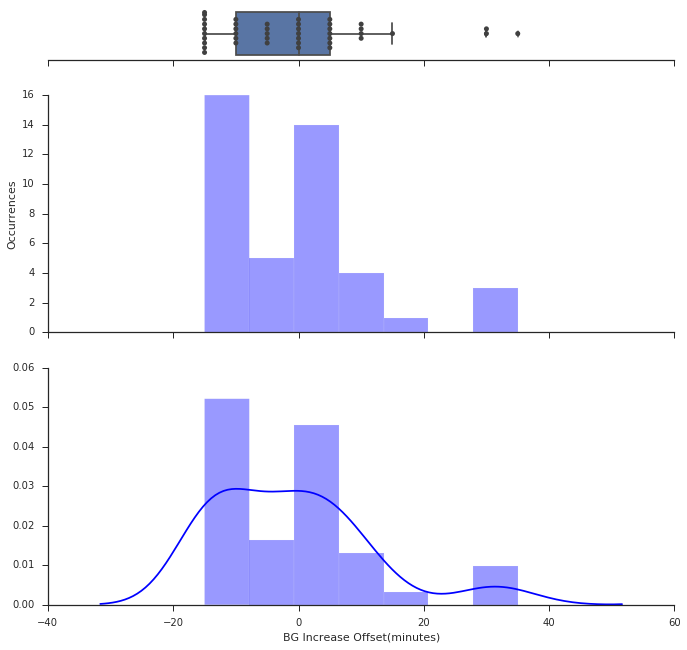

In [57]:
print "The average duration between the actual meal time and BG increase point is:", round(np.mean(time_offset),0), "minutes with a std of", round(np.std(time_offset),0), "minutes."

import seaborn as sns

sns.set(style="ticks")

f, (ax_box, ax_hist1, ax_hist2) = plt.subplots(3, sharex=True, 
                                    gridspec_kw={"height_ratios": (.10, .45, .45)}, figsize=(10,10))

b = sns.boxplot(time_offset, ax=ax_box)
sns.swarmplot(time_offset, ax=ax_box, color=".25")

bin_size = len(time_offset)/ 6       
h1 = sns.distplot( time_offset, ax=ax_hist1, bins=bin_size, kde=False, color='b')
h2 = sns.distplot( time_offset, ax=ax_hist2, bins=bin_size, kde=True, color='b')

h1.set(xlabel='', ylabel='Occurrences')

h2.set(xlabel='BG Increase Offset(minutes)', ylabel='')

# Y axis in h2 is unitless measurement but any mesaurable area under the curve can be interpreted as a probability estimate.
b.set(xlabel='')

ax_box.set( yticks=[])
sns.despine(ax=ax_hist1)
sns.despine(ax=ax_hist2)
sns.despine(ax=ax_box, left=True)

#reset to original plotting format, instead of seaborn

sns.reset_orig()



---------------------------------------

Aggregate all meals in one day chart to visualize meal timing pattern.



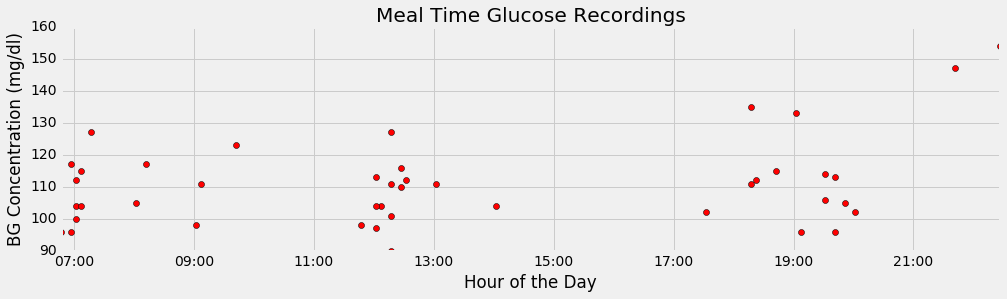

In [58]:
print "\n---------------------------------------"
print "\nAggregate all meals in one day chart to visualize meal timing pattern.\n"



df_P_all_clean_1day = copy.deepcopy(df_P_meals_w_deletion_v2)

d = datetime.datetime.today()
for i in range(len(df_P_all_clean_1day)):
    dt = df_P_all_clean_1day.Date[i].replace(year=d.year, month=d.month, day=d.day)    
    df_P_all_clean_1day.Date[i] = dt

fig = plt.figure(figsize= (15,15))
plt.subplots_adjust(hspace=0.5)

sub1 = fig.add_subplot(311)
sub1.set_xlabel('Hour of the Day')
sub1.set_ylabel('BG Concentration (mg/dl)')
sub1.set_title('Meal Time Glucose Recordings')
plt.plot_date(df_P_all_clean_1day.Date, df_P_all_clean_1day['mg/dL'], 'ro')  

xfmt = dates.DateFormatter('%H:%M')
#xfmt = dates.DateFormatter('%d-%m-%y %H:%M')
sub1.xaxis.set_major_formatter(xfmt)

plt.show()

After adjusting the meal time, we notice that new meal times have a lower BG than original recorded meal times.

This method is considered a significant improvement than using original meal times since it allows to get the postprandial signal from the start of BG INCREASE, instead of the meal time where BG may not start to increase until few minutes later.

In [59]:
# print df_P_meals_w_deletion_v2.shape[0]
# print peak_points_df.shape[0]

## All preprocessing is complete!!! Now, data analysis.

Replace the increase_pts dataframe CHO, Protein, Fats columns with values of the corresponding meals. This dataframe will be used for data analysis.

In [60]:

for k in range(df_P_meals_w_deletion_v2.shape[0]):
    increase_pts_df.set_value(k,'CHO (g)',df_P_meals_w_deletion_v2['CHO (g)'][k])
    increase_pts_df.set_value(k,'Fat (g)',df_P_meals_w_deletion_v2['Fat (g)'][k])
    increase_pts_df.set_value(k,'Protein (g)',df_P_meals_w_deletion_v2['Protein (g)'][k])
    
#print increase_pts_df